# Tokenization and sentence split


Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens

In [ ]:
!pip install nltk
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 23.1 MB/s eta 0:00:00


## Standard tokenization packages

Let's try to tokenize the following string

In [ ]:
string_to_tokeinze = "А.Б. Иванов Служит в фирме А.Б.В. уже 50 лет,т.е. полвека!"

There are many approachs for text tokenization. Let's look through the most common

`str.split(sep=None, maxsplit=-1)`

Return a list of the words in the string, using sep as the delimiter string. If maxsplit is given, at most maxsplit splits are done (thus, the list will have at most maxsplit+1 elements). If maxsplit is not specified or -1, then there is no limit on the number of splits (all possible splits are made)

In [ ]:
string_to_tokeinze.split()

['А.Б.',
 'Иванов',
 'Служит',
 'в',
 'фирме',
 'А.Б.В.',
 'уже',
 '50',
 'лет,т.е.',
 'полвека!']

**NLTK** is a leading platform for building Python programs to work with human language data.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
word_tokenize(string_to_tokeinze)

['А.Б',
 '.',
 'Иванов',
 'Служит',
 'в',
 'фирме',
 'А.Б.В',
 '.',
 'уже',
 '50',
 'лет',
 ',',
 'т.е',
 '.',
 'полвека',
 '!']

**razdel** — rule-based system for Russian sentence and word tokenization. See natasha.github.io article for more info.

In [ ]:
from razdel import tokenize

In [ ]:
list(tokenize(string_to_tokeinze))[:3]

[Substring(0, 1, 'А'), Substring(1, 2, '.'), Substring(2, 3, 'Б')]

In [ ]:
[element.text for element in list(tokenize(string_to_tokeinze))]

['А',
 '.',
 'Б',
 '.',
 'Иванов',
 'Служит',
 'в',
 'фирме',
 'А',
 '.',
 'Б',
 '.',
 'В',
 '.',
 'уже',
 '50',
 'лет',
 ',',
 'т',
 '.',
 'е',
 '.',
 'полвека',
 '!']

### Word tokenzation packages analysis

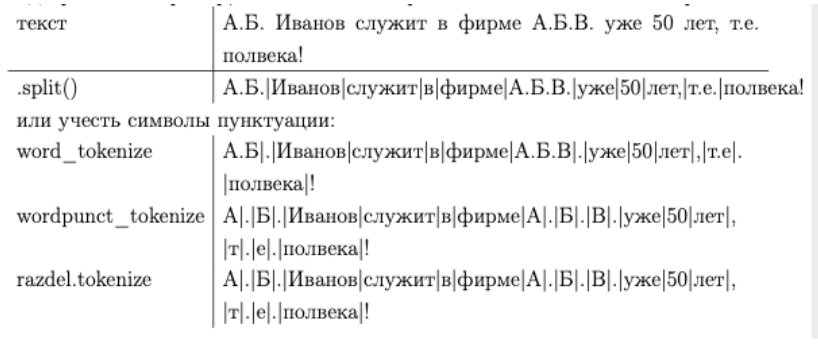

The sample has been taken from the following source: 
*Куратов Юрий Михайлович (2020). Специализация языковых моделей для применения к задачам обработки естественного языка. МФТИ. Москва*

|                         | Erorrs per 1000 tokens |Processing time, sec|
|-------------------------|------------------------|--------------------------|
| Regexp-baseline         | 19                     | 0.5                      |
| SpaCy                   | 17                     | 5.4                      |
| NLTK                    | 130                    | 3.1                      |
| MyStem                  | 19                     | 4.5                      |
| Moses                   | 11                     | 1.9                      |
| SegTok                  | 12                     | 2.1                      |
| SpaCy Russian Tokenizer | 8                      | 46.4                     |
| RuTokenizer             | 15                     | 1.0                      |
| Razdel                  | 7                      | 2.6                      |

## Byte-pair-encoding

![](https://hsto.org/getpro/habr/upload_files/3bf/fbb/379/3bffbb379f869f8ec9214b364a641277.jpeg)



A simple data compression algorithm first [introduced in 1994](https://www.derczynski.com/papers/archive/BPE_Gage.pdf). It was later reintroudiced for NLP to the task of word segmentation in [this article](https://arxiv.org/pdf/1508.07909.pdf). BPE allows for the
representation of an open vocabulary through
a fixed-size vocabulary of variable-length
character sequences, making it a very suitable word segmentation strategy for neural
network models.

In [ ]:
from transformers import GPT2Tokenizer
model_name_or_path = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)

In [ ]:
text = "Токенизируй меня" 
tokens = tokenizer.encode(text, add_special_tokens=False) 
decoded_tokens = [tokenizer.decode([token]) for token in tokens] 


print("text:           ", text)
print("decoded tokens: ", decoded_tokens)
print("tokens:         ", tokens)

text:            Токенизируй меня
decoded tokens:  ['Т', 'ок', 'ени', 'зи', 'руй', ' меня']
tokens:          [789, 368, 337, 848, 28306, 703]


[More examples for GPT](https://habr.com/ru/post/599673/) 

### BPE simple version 

The code below shows a toy example of learned BPE operations. At test time, we first split words into sequences of characters, then apply the learned operations to merge the characters into larger, known symbols. This is applicable to any word, and allows for open-vocabulary networks with fixed symbol vocabularies. In our example, the ‘lower’ would be segmented into ‘low er·’

In [ ]:
# assuming we've extracted from our raw text a vocabulary along with its frequency
vocab = {
    'l o w </w>': 5,
    'l o w e r </w>': 2,
    'n e w e s t </w>': 6,
    'w i d e s t </w>': 3,
    'h a p p i e r </w>': 2
}

def get_pair_stats(vocab):
    """Get counts of pairs of consecutive symbols."""

    pairs = {}
    for word, frequency in vocab.items():
        symbols = word.split()

        # count occurrences of pairs
        for i in range(len(symbols) - 1):
            pair = (symbols[i], symbols[i + 1])
            current_frequency = pairs.get(pair, 0)
            pairs[pair] = current_frequency + frequency

    return pairs



In [ ]:
pair_stats = get_pair_stats(vocab)
pair_stats

{('l', 'o'): 7,
 ('o', 'w'): 7,
 ('w', '</w>'): 5,
 ('w', 'e'): 8,
 ('e', 'r'): 4,
 ('r', '</w>'): 4,
 ('n', 'e'): 6,
 ('e', 'w'): 6,
 ('e', 's'): 9,
 ('s', 't'): 9,
 ('t', '</w>'): 9,
 ('w', 'i'): 3,
 ('i', 'd'): 3,
 ('d', 'e'): 3,
 ('h', 'a'): 2,
 ('a', 'p'): 2,
 ('p', 'p'): 2,
 ('p', 'i'): 2,
 ('i', 'e'): 2}

In [ ]:
def merge_vocab(best_pair, vocab_in):
    """Step 3. Merge all occurrences of the most frequent pair"""

    vocab_out = {}

    # re.escape
    # ensures the characters of our input pair will be handled as is and
    # not get mistreated as special characters in the regular expression ([],\ etc.).
    pattern = re.escape(' '.join(best_pair))
    replacement = ''.join(best_pair)

    for word_in in vocab_in:
        # replace most frequent pair in all vocabulary
        word_out = re.sub(pattern, replacement, word_in)
        vocab_out[word_out] = vocab_in[word_in]

    return vocab_out

In [ ]:
best_pair = max(pair_stats, key=pair_stats.get)
print("best_pair:", best_pair)

new_vocab = merge_vocab(best_pair, vocab)
new_vocab

best_pair: ('e', 's')


{'l o w </w>': 5,
 'l o w e r </w>': 2,
 'n e w es t </w>': 6,
 'w i d es t </w>': 3,
 'h a p p i e r </w>': 2}

In [ ]:
vocab = {
    'l o w </w>': 5,
    'l o w e r </w>': 2,
    'n e w e s t </w>': 6,
    'w i d e s t </w>': 3,
    'h a p p i e r </w>': 2
}

# we store the best pair during each iteration for encoding new vocabulary, more on this later
bpe_codes = {}
num_merges = 10  # hyperparameter
for i in range(num_merges):
    print('\niteration', i)
    pair_stats = get_pair_stats(vocab)
    if not pair_stats:
        break

    best_pair = max(pair_stats, key=pair_stats.get)
    bpe_codes[best_pair] = i

    print('vocabulary: ', vocab)
    print('best pair:', best_pair)
    vocab = merge_vocab(best_pair, vocab)

print('\nfinal vocabulary: ', vocab)
print('\nbyte pair encoding: ', bpe_codes)


iteration 0
vocabulary:  {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3, 'h a p p i e r </w>': 2}
best pair: ('e', 's')

iteration 1
vocabulary:  {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3, 'h a p p i e r </w>': 2}
best pair: ('es', 't')

iteration 2
vocabulary:  {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3, 'h a p p i e r </w>': 2}
best pair: ('est', '</w>')

iteration 3
vocabulary:  {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3, 'h a p p i e r </w>': 2}
best pair: ('l', 'o')

iteration 4
vocabulary:  {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3, 'h a p p i e r </w>': 2}
best pair: ('lo', 'w')

iteration 5
vocabulary:  {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3, 'h a p p i e r </w>': 2}
best pair: ('n', 'e')

iteration 6
vocabulary:  {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>'

In [ ]:
bpe_codes

{('e', 's'): 0,
 ('es', 't'): 1,
 ('est', '</w>'): 2,
 ('l', 'o'): 3,
 ('lo', 'w'): 4,
 ('n', 'e'): 5,
 ('ne', 'w'): 6,
 ('new', 'est</w>'): 7,
 ('low', '</w>'): 8,
 ('e', 'r'): 9}

In [ ]:
vocab

{'low</w>': 5,
 'low er </w>': 2,
 'newest</w>': 6,
 'w i d est</w>': 3,
 'h a p p i er </w>': 2}

### BPE advanced version implementation

Let's look through more advanced implementation of byte pairs encoding algo from [here](https://github.com/soaxelbrooke/python-bpe/blob/master/bpe/encoder.py)

In [ ]:
from collections import Counter

try:
    from typing import Dict, Iterable, Callable, List, Any, Iterator
except ImportError:
    pass

from nltk.tokenize import wordpunct_tokenize
from tqdm import tqdm
import toolz
import json

DEFAULT_EOW = '__eow'
DEFAULT_SOW = '__sow'
DEFAULT_UNK = '__unk'
DEFAULT_PAD = '__pad'


class Encoder:
    """ Encodes white-space separated text using byte-pair encoding.  See https://arxiv.org/abs/1508.07909 for details.
    """

    def __init__(self, vocab_size=8192, pct_bpe=0.2, word_tokenizer=None,
                 silent=True, ngram_min=2, ngram_max=2, required_tokens=None,
                 strict=False, lowercase=True,
                 EOW=DEFAULT_EOW, SOW=DEFAULT_SOW, UNK=DEFAULT_UNK, PAD=DEFAULT_PAD):
        if vocab_size < 1:
            raise ValueError('vocab size must be greater than 0.')

        self.EOW = EOW
        self.SOW = SOW
        self.eow_len = len(EOW)
        self.sow_len = len(SOW)
        self.UNK = UNK
        self.PAD = PAD
        self.required_tokens = list(set(required_tokens or []).union({self.UNK, self.PAD}))
        self.vocab_size = vocab_size #how many unique tokens will you get in the end
        self.pct_bpe = pct_bpe #percent of words which will be decomposed into subtokens using bpe algorithm
        self.word_vocab_size = max([int(vocab_size * (1 - pct_bpe)), len(self.required_tokens or [])])#how many full-word tokens will be among final tokens
        self.bpe_vocab_size = vocab_size - self.word_vocab_size#how many bpe subtokens will be among final tokens
        self.word_tokenizer = word_tokenizer if word_tokenizer is not None else wordpunct_tokenize
        self.custom_tokenizer = word_tokenizer is not None
        self.word_vocab = {}  # type: Dict[str, int]
        self.bpe_vocab = {}  # type: Dict[str, int]
        self.inverse_word_vocab = {}  # type: Dict[int, str]
        self.inverse_bpe_vocab = {}  # type: Dict[int, str]
        self._progress_bar = iter if silent else tqdm
        self.ngram_min = ngram_min
        self.ngram_max = ngram_max
        self.strict = strict
        self.lowercase = lowercase

    def mute(self):
        """ Turn on silent mode """
        self._progress_bar = iter

    def unmute(self):
        """ Turn off silent mode """
        self._progress_bar = tqdm

    def byte_pair_counts(self, words):
        # type: (Encoder, Iterable[str]) -> Iterable[Counter]
        """ Counts space separated token character pairs:
            [('T h i s </w>', 4}] -> {'Th': 4, 'hi': 4, 'is': 4}
        """
        for token, count in self._progress_bar(self.count_tokens(words).items()):
            bp_counts = Counter()  # type: Counter
            for ngram in token.split(' '):
                bp_counts[ngram] += count#count single letter
            for ngram_size in range(self.ngram_min, min([self.ngram_max, len(token)]) + 1):#count ngramms 
                ngrams = [''.join(ngram) for ngram in toolz.sliding_window(ngram_size, token.split(' '))]
                for ngram in ngrams:
                    bp_counts[''.join(ngram)] += count
            yield bp_counts

    def count_tokens(self, words):
        # type: (Encoder, Iterable[str]) -> Dict[str, int]
        """ Count tokens into a BPE vocab """
        token_counts = Counter(self._progress_bar(words))
        return {' '.join(token): count for token, count in token_counts.items()}

    def learn_word_vocab(self, sentences):
        # type: (Encoder, Iterable[str]) -> Dict[str, int]
        """ Build vocab from self.word_vocab_size most common tokens in provided sentences """
        word_counts = Counter(word for word in toolz.concat(map(self.word_tokenizer, sentences)))#tokenize words and count occurencies in text
        for token in set(self.required_tokens or []):
            word_counts[token] = int(2**63)#set nrequired tokens frequency to big value so thewy will be in the beginning og the sorted frequencies dict    
        sorted_word_counts = sorted(word_counts.items(), key=lambda p: -p[1])#sort word frequency dict 
        return {word: idx for idx, (word, count) in enumerate(sorted_word_counts[:self.word_vocab_size])} 

    def learn_bpe_vocab(self, words):
        # type: (Encoder, Iterable[str]) -> Dict[str, int]
        """ Learns a vocab of byte pair encodings """
        vocab = Counter()  # type: Counter
        for token in {self.SOW, self.EOW}:
            vocab[token] = int(2**63)
        for idx, byte_pair_count in enumerate(self.byte_pair_counts(words)):#extract ngrams with size from ngram_min to ngram_max
            for byte_pair, count in byte_pair_count.items():
                vocab[byte_pair] += count

            if (idx + 1) % 10000 == 0:
                self.trim_vocab(10 * self.bpe_vocab_size, vocab)#delete rare pairs in case of big pairs quantity
        #sort subtokens dict by frequency and return the number of tokens equals to self.bpe_vocab_size
        sorted_bpe_counts = sorted(vocab.items(), key=lambda p: -p[1])[:self.bpe_vocab_size]
        return {bp: idx + self.word_vocab_size for idx, (bp, count) in enumerate(sorted_bpe_counts)}

    def fit(self, text):
        # type: (Encoder, Iterable[str]) -> None
        """ Learn vocab from text. """
        if self.lowercase:
            _text = [l.lower().strip() for l in text]
        else:
            _text = [l.strip() for l in text]
        # First, learn word vocab
        self.word_vocab = self.learn_word_vocab(_text)#get word:id dict with most frequent words from text - these words will be leaft intact in final tokens list
        remaining_words = [word for word in toolz.concat(map(self.word_tokenizer, _text))
                           if word not in self.word_vocab]#words to be processed with bpe algo
        self.bpe_vocab = self.learn_bpe_vocab(remaining_words)

        self.inverse_word_vocab = {idx: token for token, idx in self.word_vocab.items()}
        self.inverse_bpe_vocab = {idx: token for token, idx in self.bpe_vocab.items()}

    @staticmethod
    def trim_vocab(n, vocab):
        # type: (int, Dict[str, int]) -> None
        """  Deletes all pairs below 10 * vocab size to prevent memory problems """
        pair_counts = sorted(vocab.items(), key=lambda p: -p[1])
        pairs_to_trim = [pair for pair, count in pair_counts[n:]]
        for pair in pairs_to_trim:
            del vocab[pair]

    def subword_tokenize(self, word):
        # type: (Encoder, str) -> List[str]
        """ Tokenizes inside an unknown token using BPE """
        end_idx = min([len(word), self.ngram_max])
        sw_tokens = [self.SOW]
        start_idx = 0

        while start_idx < len(word):
            subword = word[start_idx:end_idx]
            if subword in self.bpe_vocab:
                sw_tokens.append(subword)
                start_idx = end_idx
                end_idx = min([len(word), start_idx + self.ngram_max])
            elif len(subword) == 1:#the word is not found 
                sw_tokens.append(self.UNK)
                start_idx = end_idx
                end_idx = min([len(word), start_idx + self.ngram_max])
            else:
                end_idx -= 1

        sw_tokens.append(self.EOW)
        return sw_tokens

    def tokenize(self, sentence):
        # type: (Encoder, str) -> List[str]
        """ Split a sentence into word and subword tokens """
        if self.lowercase:
            word_tokens = self.word_tokenizer(sentence.lower().strip())
        else:
            word_tokens = self.word_tokenizer(sentence.strip())
        tokens = []
        for word_token in word_tokens:
            if word_token in self.word_vocab:#if word token among full words tokens of Encoder then use the exact word token
                tokens.append(word_token)
            else: #otherwise compose word from bpe tokens
                tokens.extend(self.subword_tokenize(word_token))

        return tokens

    def transform(self, sentences, reverse=False, fixed_length=None):
        # type: (Encoder, Iterable[str], bool, int) -> Iterable[List[int]]
        """ Turns space separated tokens into vocab idxs """
        direction = -1 if reverse else 1
        for sentence in self._progress_bar(sentences):
            in_subword = False
            encoded = []
            if self.lowercase:
                tokens = list(self.tokenize(sentence.lower().strip()))
            else:
                tokens = list(self.tokenize(sentence.strip()))
            for token in tokens:
                if in_subword:
                    if token in self.bpe_vocab:
                        if token == self.EOW:
                            in_subword = False
                        encoded.append(self.bpe_vocab[token])
                    else:
                        encoded.append(self.word_vocab[self.UNK])
                else:
                    if token == self.SOW:
                        in_subword = True
                        encoded.append(self.bpe_vocab[token])
                    else:
                        if token in self.word_vocab:
                            encoded.append(self.word_vocab[token])
                        else:
                            encoded.append(self.word_vocab[self.UNK])

            if fixed_length is not None:
                encoded = encoded[:fixed_length]
                while len(encoded) < fixed_length:
                    encoded.append(self.word_vocab[self.PAD])

            yield encoded[::direction]

    def inverse_transform(self, rows):
        # type: (Encoder, Iterable[List[int]]) -> Iterator[str]
        """ Turns token indexes back into space-joined text. """
        for row in rows:
            words = []

            rebuilding_word = False
            current_word = ''
            for idx in row:
                if self.inverse_bpe_vocab.get(idx) == self.SOW:
                    if rebuilding_word and self.strict:
                        raise ValueError('Encountered second SOW token before EOW.')
                    rebuilding_word = True

                elif self.inverse_bpe_vocab.get(idx) == self.EOW:
                    if not rebuilding_word and self.strict:
                        raise ValueError('Encountered EOW without matching SOW.')
                    rebuilding_word = False
                    words.append(current_word)
                    current_word = ''

                elif rebuilding_word and (idx in self.inverse_bpe_vocab):
                    current_word += self.inverse_bpe_vocab[idx]

                elif rebuilding_word and (idx in self.inverse_word_vocab):
                    current_word += self.inverse_word_vocab[idx]

                elif idx in self.inverse_word_vocab:
                    words.append(self.inverse_word_vocab[idx])

                elif idx in self.inverse_bpe_vocab:
                    if self.strict:
                        raise ValueError("Found BPE index {} when not rebuilding word!".format(idx))
                    else:
                        words.append(self.inverse_bpe_vocab[idx])

                else:
                    raise ValueError("Got index {} that was not in word or BPE vocabs!".format(idx))

            yield ' '.join(w for w in words if w != '')

    def vocabs_to_dict(self, dont_warn=False):
        # type: (Encoder, bool) -> Dict[str, Dict[str, int]]
        """ Turns vocab into dict that is json-serializeable """
        if self.custom_tokenizer and not dont_warn:
            print("WARNING! You've specified a non-default tokenizer.  You'll need to reassign it when you load the "
                  "model!")
        return {
            'byte_pairs': self.bpe_vocab,
            'words': self.word_vocab,
            'kwargs': {
                'vocab_size': self.vocab_size,
                'pct_bpe': self.pct_bpe,
                'silent': self._progress_bar is iter,
                'ngram_min': self.ngram_min,
                'ngram_max': self.ngram_max,
                'required_tokens': self.required_tokens,
                'strict': self.strict,
                'EOW': self.EOW,
                'SOW': self.SOW,
                'UNK': self.UNK,
                'PAD': self.PAD,
            }
        }

    def save(self, outpath, dont_warn=False):
        # type: (Encoder, str, bool) -> None
        """ Serializes and saves encoder to provided path """
        with open(outpath, 'w') as outfile:
            json.dump(self.vocabs_to_dict(dont_warn), outfile)

    @classmethod
    def from_dict(cls, vocabs):
        # type: (Any, Dict[str, Dict[str, int]]) -> Encoder
        """ Load encoder from dict produced with vocabs_to_dict """
        encoder = Encoder(**vocabs['kwargs'])
        encoder.word_vocab = vocabs['words']
        encoder.bpe_vocab = vocabs['byte_pairs']

        encoder.inverse_bpe_vocab = {v: k for k, v in encoder.bpe_vocab.items()}
        encoder.inverse_word_vocab = {v: k for k, v in encoder.word_vocab.items()}

        return encoder

    @classmethod
    def load(cls, in_path):
        # type: (Any, str) -> Encoder
        """ Loads an encoder from path saved with save """
        with open(in_path) as infile:
            obj = json.load(infile)
        return cls.from_dict(obj)

### BPE advanced version inference

In [ ]:
test_corpus = '''
    Object raspberrypi functools dict kwargs. Gevent raspberrypi functools. Dunder raspberrypi decorator dict didn't lambda zip import pyramid, she lambda iterate?
    Kwargs raspberrypi diversity unit object gevent. Import fall integration decorator unit django yield functools twisted. Dunder integration decorator he she future. Python raspberrypi community pypy. Kwargs integration beautiful test reduce gil python closure. Gevent he integration generator fall test kwargs raise didn't visor he itertools...
    Reduce integration coroutine bdfl he python. Cython didn't integration while beautiful list python didn't nit!
    Object fall diversity 2to3 dunder script. Python fall for: integration exception dict kwargs dunder pycon. Import raspberrypi beautiful test import six web. Future integration mercurial self script web. Return raspberrypi community test she stable.
    Django raspberrypi mercurial unit import yield raspberrypi visual rocksdahouse. Dunder raspberrypi mercurial list reduce class test scipy helmet zip?
'''

encoder = Encoder(200, pct_bpe=0.75)
encoder.fit(test_corpus.split('\n'))

In [ ]:
list(encoder.word_vocab.items())[:10]

[('__unk', 0),
 ('__pad', 1),
 ('.', 2),
 ('raspberrypi', 3),
 ('integration', 4),
 ('kwargs', 5),
 ('dunder', 6),
 ('import', 7),
 ('python', 8),
 ('test', 9)]

In [ ]:
list(encoder.bpe_vocab.items())[:30]

[('__eow', 50),
 ('__sow', 51),
 ('e', 52),
 ('s', 53),
 ('t', 54),
 ('o', 55),
 ('c', 56),
 ('i', 57),
 ('l', 58),
 ('n', 59),
 ('h', 60),
 ('r', 61),
 ('a', 62),
 ('y', 63),
 ('on', 64),
 ('p', 65),
 ('u', 66),
 ('ho', 67),
 ('le', 68),
 ('f', 69),
 ('x', 70),
 ('py', 71),
 ('se', 72),
 ('el', 73),
 ('et', 74),
 ('cy', 75),
 ('yt', 76),
 ('th', 77),
 ('w', 78),
 ('wh', 79)]

In [ ]:
example = "Vizzini: He didn't fall? INCONCEIVABLE!"
print(encoder.tokenize(example))

['__sow', 'vi', '__unk', '__unk', 'i', 'ni', '__eow', '__sow', ':', '__eow', 'he', 'didn', "'", 't', 'fall', '?', '__sow', 'i', 'n', 'co', 'n', 'ce', 'i', 'v', 'ab', 'le', '__eow', '__sow', '!', '__eow']


In [ ]:
print(next(encoder.transform([example])))

[51, 115, 0, 0, 57, 82, 50, 51, 92, 50, 14, 10, 11, 12, 13, 27, 51, 57, 59, 101, 59, 95, 57, 114, 112, 68, 50, 51, 84, 50]


In [ ]:
print(next(encoder.inverse_transform(encoder.transform([example]))))

vi__unk__unkini : he didn ' t fall ? inconceivable !
